### I - Data manipulation

#### Imports libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

#### Import data 

In [2]:
directory = '../../Database'
data = 'card_transaction_2.csv'

df = pd.read_csv(directory+'/'+data)

#### Explore data

In [3]:
pd.set_option('display.max_columns', None)
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2015,11,15,12:55,287.13,Online Transaction,-8194607650924472520,ONLINE,NaN,NaN,3001,NaN,Yes
1,0,0,2015,11,15,13:19,2.41,Online Transaction,-7759074308363763111,ONLINE,NaN,NaN,5651,NaN,Yes
2,0,0,2015,11,16,09:41,50.81,Online Transaction,-551332107213382088,ONLINE,NaN,NaN,4411,NaN,Yes
3,0,0,2015,11,16,09:46,248.36,Online Transaction,4872340518840476610,ONLINE,NaN,NaN,5732,NaN,Yes
4,0,0,2015,11,16,11:20,473.00,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes
5,0,0,2015,11,16,11:34,144.49,Online Transaction,-3650057525483423997,ONLINE,NaN,NaN,3007,NaN,Yes
6,0,0,2015,11,16,13:44,44.57,Online Transaction,1913477460590765860,ONLINE,NaN,NaN,5300,NaN,Yes
7,0,0,2015,11,17,14:12,64.93,Online Transaction,4645744106416199425,ONLINE,NaN,NaN,7996,NaN,Yes
8,0,0,2015,11,17,15:35,124.59,Online Transaction,9057735476014445185,ONLINE,NaN,NaN,5311,NaN,Yes
9,0,0,2015,11,17,15:59,97.34,Online Transaction,5625828905483550857,ONLINE,NaN,NaN,7922,NaN,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59514 entries, 0 to 59513
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            59514 non-null  int64  
 1   Card            59514 non-null  int64  
 2   Year            59514 non-null  int64  
 3   Month           59514 non-null  int64  
 4   Day             59514 non-null  int64  
 5   Time            59514 non-null  object 
 6   Amount          59514 non-null  float64
 7   Use Chip        59514 non-null  object 
 8   Merchant Name   59514 non-null  int64  
 9   Merchant City   59514 non-null  object 
 10  Merchant State  37895 non-null  object 
 11  Zip             31215 non-null  float64
 12  MCC             59514 non-null  int64  
 13  Errors?         1778 non-null   object 
 14  Is Fraud?       59514 non-null  object 
dtypes: float64(2), int64(7), object(6)
memory usage: 6.8+ MB


In [5]:
df.describe()

,User,Card,Year,Month,Day,Amount,Merchant Name,Zip,MCC
count,59514.000000,59514.000000,59514.000000,59514.000000,59514.000000,59514.000000,5.951400e+04,31215.00000,59514.000000
mean,1003.264492,1.491464,2011.950129,6.582048,15.722485,76.199462,-1.519069e+17,51200.60567,5409.848153
std,565.443021,1.478983,4.883307,3.468755,8.826830,156.344464,4.835683e+18,29251.28779,951.565089
min,0.000000,0.000000,1991.000000,1.000000,1.000000,-500.000000,-9.209172e+18,1057.00000,1711.000000
25%,520.000000,0.000000,2008.000000,4.000000,8.000000,11.880000,-4.282467e+18,28722.00000,5094.000000
50%,1009.000000,1.000000,2012.000000,7.000000,16.000000,44.860000,-2.451783e+17,46237.00000,5411.000000
75%,1478.000000,2.000000,2016.000000,10.000000,23.000000,100.000000,3.991321e+18,77584.00000,5812.000000
max,1999.000000,8.000000,2020.000000,12.000000,31.000000,5694.440000,9.222877e+18,99517.00000,9402.000000


#### Clean data

In [6]:
df['Is Fraud?'] = df['Is Fraud?'].map({'Yes': 1, 'No': 0})
df['Time'] = df['Time'].apply(lambda x: int(x[:2])*60+int(x[3:]))
df['Use Chip'] = df['Use Chip'].map({"Chip Transaction": 0, "Online Transaction": 1, "Swipe Transaction": 2})
label_encoder = LabelEncoder()
df['Merchant Name'] = df['Merchant Name'].astype("string")
df['Merchant Name'] = label_encoder.fit_transform(df['Merchant Name'])
df['Merchant City'] = label_encoder.fit_transform(df['Merchant City'])
df['Merchant State'].fillna("ONLINE", inplace=True)
df['Merchant State'] = label_encoder.fit_transform(df['Merchant State'])
df = df.drop('Zip', axis=1)
df['Errors?'].fillna("None", inplace=True)
df['Errors?'] = label_encoder.fit_transform(df['Errors?'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59514 entries, 0 to 59513
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            59514 non-null  int64  
 1   Card            59514 non-null  int64  
 2   Year            59514 non-null  int64  
 3   Month           59514 non-null  int64  
 4   Day             59514 non-null  int64  
 5   Time            59514 non-null  int64  
 6   Amount          59514 non-null  float64
 7   Use Chip        59514 non-null  int64  
 8   Merchant Name   59514 non-null  int32  
 9   Merchant City   59514 non-null  int32  
 10  Merchant State  59514 non-null  int32  
 11  MCC             59514 non-null  int64  
 12  Errors?         59514 non-null  int32  
 13  Is Fraud?       59514 non-null  int64  
dtypes: float64(1), int32(4), int64(9)
memory usage: 5.4 MB


#### Use data

In [8]:
fraud = df[df['Is Fraud?']== 1].sample(1000)
normal = df[df['Is Fraud?']== 0].sample(5000)
df = pd.concat([normal, fraud]).reset_index(drop=True)

In [9]:
X, y = df.drop('Is Fraud?', axis=1), df['Is Fraud?']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            6000 non-null   int64  
 1   Card            6000 non-null   int64  
 2   Year            6000 non-null   int64  
 3   Month           6000 non-null   int64  
 4   Day             6000 non-null   int64  
 5   Time            6000 non-null   int64  
 6   Amount          6000 non-null   float64
 7   Use Chip        6000 non-null   int64  
 8   Merchant Name   6000 non-null   int32  
 9   Merchant City   6000 non-null   int32  
 10  Merchant State  6000 non-null   int32  
 11  MCC             6000 non-null   int64  
 12  Errors?         6000 non-null   int32  
 13  Is Fraud?       6000 non-null   int64  
dtypes: float64(1), int32(4), int64(9)
memory usage: 562.6 KB


#### Visualize data

In [11]:
def data_plot(x, y):
    sns.set(style = 'whitegrid')
    tsne = TSNE(n_components=2, random_state=0)
    X_transformed = tsne.fit_transform(x)
    
    plt.figure(figsize=(10,10))
    
    plt.scatter(X_transformed[np.where(y==0), 0],
                X_transformed[np.where(y==0), 1],
                marker = 'o',
                color = 'y',
                linewidth = 1,
                alpha = 0.8,
                label = 'Normal')
    
    plt.scatter(X_transformed[np.where(y==1), 0],
                X_transformed[np.where(y==1), 1],
                marker = 'o',
                color = 'k',
                linewidth = 1,
                alpha = 0.8,
                label = 'Fraud')
    
    plt.legend(loc='best')
    plt.show()

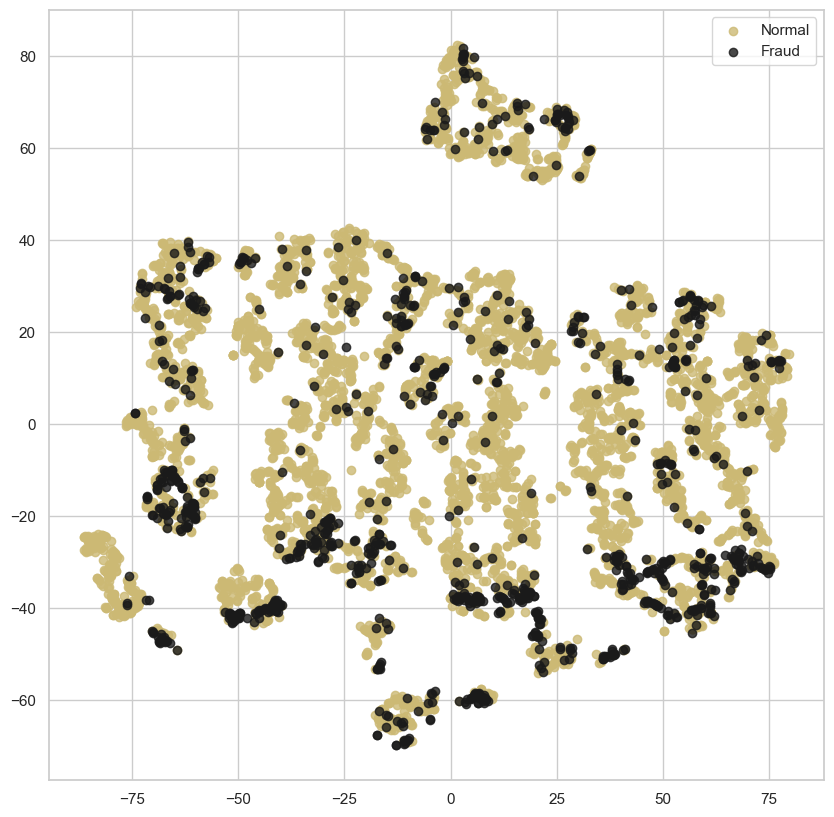

In [12]:
data_plot(X, y)

### II - Data processing

#### Clean data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#### Setup model

In [14]:
def create_autoencoder_model():
    autoencoder = Sequential()
    autoencoder.add(Dense(60, input_dim=X_train_resampled.shape[1], activation='tanh'))
    autoencoder.add(Dense(30, activation='relu'))
    autoencoder.add(Dense(16, activation='relu'))
    autoencoder.add(Dense(13, activation='sigmoid'))
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return autoencoder

##### ----->      GridSearchCV

In [15]:
param_grid = {
    'batch_size': [8, 16],
    'epochs': [20, 30],
}

In [16]:
autoencoder_model = KerasClassifier(build_fn=create_autoencoder_model, verbose=0)

grid = GridSearchCV(estimator=autoencoder_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(X_train_resampled, X_train_resampled)

print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

best_autoencoder = grid_result.best_estimator_.model
autoencoder = best_autoencoder

84/84 [==============================] - 0s 1ms/step
Best Parameters:  {'batch_size': 8, 'epochs': 20}
Best Accuracy:  nan


#### Train model

In [17]:
autoencoder.fit(X_train_resampled,
                X_train_resampled,
                batch_size = 16,
                epochs = 20,
                shuffle = True,
                validation_split = 0.20)

Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.4637 - accuracy: 0.8172 - val_loss: 0.4870 - val_accuracy: 0.8667
Epoch 2/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8164 - val_loss: 0.4870 - val_accuracy: 0.8536
Epoch 3/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8174 - val_loss: 0.4870 - val_accuracy: 0.8680
Epoch 4/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8203 - val_loss: 0.4871 - val_accuracy: 0.8698
Epoch 5/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8200 - val_loss: 0.4869 - val_accuracy: 0.8573
Epoch 6/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8192 - val_loss: 0.4871 - val_accuracy: 0.8767
Epoch 7/20
400/400 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.8194 - val_loss: 0.4874 - val_accuracy: 0.8617
Epoch 

#### Extract encoder

In [18]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])

#### Encode data

In [19]:
resampled_hidden_rep = hidden_representation.predict(X_train_resampled)

encoded_X = resampled_hidden_rep
y_resampled = y_train_resampled

250/250 [==============================] - 0s 1ms/step


#### Visualize data

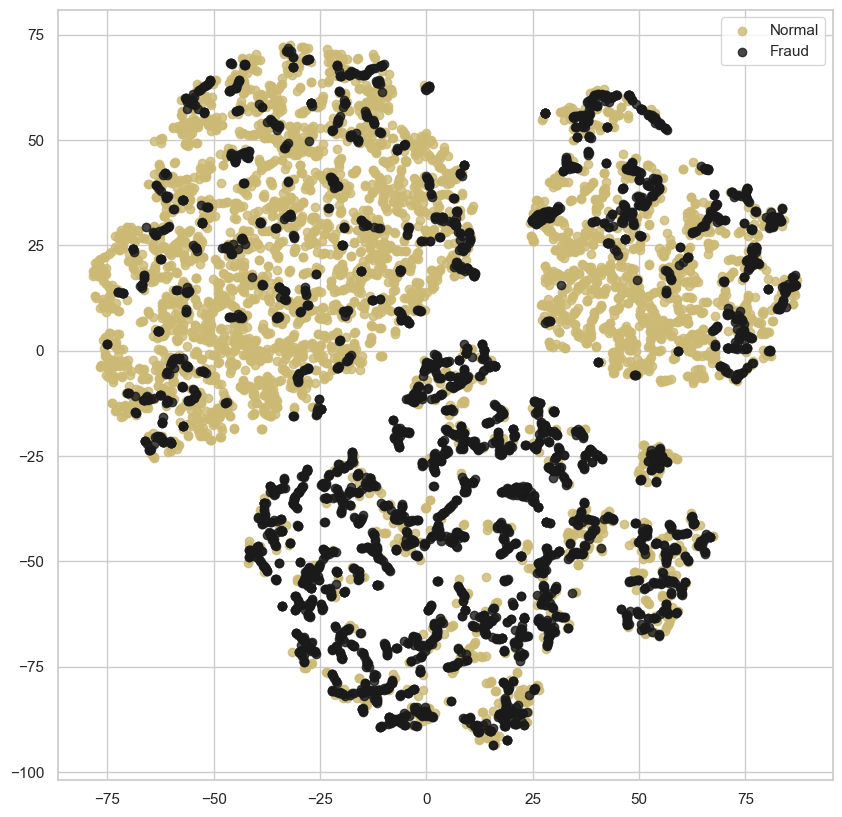

In [20]:
data_plot(encoded_X, y_resampled)

### III - Data analyzing

#### Prepare data

In [22]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, y_resampled, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Build Logistic Regression model

In [24]:
lrclf = LogisticRegression()
lrclf.fit(X_train_encoded, y_train_encoded)

y_pred_lrclf = lrclf.predict(X_test_encoded)

#### Build Support Vector Classifier model

In [25]:
svmclf = SVC()
svmclf.fit(X_train, y_train)

y_pred_svmclf = svmclf.predict(X_test)

#### Evaluate performances

In [26]:
print('Logistic Regression Accuracy : ' + str(accuracy_score(y_test_encoded, y_pred_lrclf)))
print('Support Vector Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_svmclf)))

Logistic Regression Accuracy : 0.6833541927409261
Support Vector Classifier Accuracy : 0.83
